# Architecture Playground
This notebook is a duplicate of `4 Load Images into Memory`. The end goal is to increase accuracy by tinkering with the architecture of the CNN.

#### Imports and functions

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pdb

train_path = '..//data//helen//train_rotated//'
test_path = '..//data//helen//test_rotated//'
num_classes = 4

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras import optimizers

In [3]:
def plot_figures(figures, nrows=1, ncols=1, size=8):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(size,size))
    for ind,title in enumerate(figures):
        axeslist[ind].imshow(figures[title], cmap=plt.gray())
        axeslist[ind].set_title(title)
        axeslist[ind].set_axis_off()
    plt.tight_layout() # optional

## Load in all images
We have enough memory :)

In [4]:
x_train = np.load(train_path+'x_train_rotated_bilinear.npy')
y_train = np.load(train_path+'y_train_rotated_bilinear.npy')
x_test = np.load(test_path+'x_test_rotated_bilinear.npy')
y_test = np.load(test_path+'y_test_rotated_bilinear.npy')

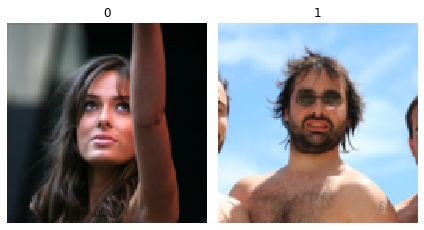

In [5]:
figures = {'0': x_train[0], '1': x_train[1]}
plot_figures(figures, 1, 2, 6)

# Current Best (standardized, bilinear) - val_acc: 0.5235
We will use the same model architecture as the previous notebook, 4-Class-CNN. We just want to make sure everything is working as expected and test the speed improvements from using images in RAM

## Standardization
Subtract mean pixel value and divide by standard deviation

0.5015 val_acc after 83 epochs

Looks like this one is the winner!

#### Verify that it works
Looks good. The mean should be closer to 0 ideally though

In [21]:
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(x_train)
# print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))
iterator = datagen.flow(x_train, y_train, batch_size=64)
batchX, batchy = iterator.next()
print(batchX.shape, batchX.mean(), batchX.std())


iterator = datagen.flow(x_train, y_train, batch_size=len(x_train), shuffle=False)
batchX, batchy = iterator.next()
print(batchX.shape, batchX.mean(), batchX.std())

(64, 128, 128, 3) 0.9526761 1.1246042
(8000, 128, 128, 3) 1.0059751 1.0923867


#### Define Train function

In [6]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)

    return history, model

#### Define Model

In [21]:
model_1 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(4),   # number of classes is 4
    Activation('softmax')
])
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_24 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_28 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_25 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_29 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 16)       

#### Execute Training

In [32]:
history, model = train(model_1)

Epoch 1/100
63/63 [==============================] - 6s 88ms/step - loss: 2.2720 - acc: 0.2587 - val_loss: 1.4177 - val_acc: 0.2303
Epoch 2/100
63/63 [==============================] - 5s 73ms/step - loss: 2.0924 - acc: 0.2623 - val_loss: 1.4171 - val_acc: 0.2477
Epoch 3/100
63/63 [==============================] - 5s 72ms/step - loss: 2.0622 - acc: 0.2585 - val_loss: 1.4226 - val_acc: 0.2598
Epoch 4/100
63/63 [==============================] - 5s 72ms/step - loss: 2.0578 - acc: 0.2627 - val_loss: 1.4313 - val_acc: 0.2659
Epoch 5/100
63/63 [==============================] - 4s 71ms/step - loss: 2.0376 - acc: 0.2587 - val_loss: 1.4408 - val_acc: 0.2909
Epoch 6/100
63/63 [==============================] - 4s 71ms/step - loss: 2.0179 - acc: 0.2680 - val_loss: 1.4519 - val_acc: 0.2886
Epoch 7/100
63/63 [==============================] - 4s 71ms/step - loss: 1.9888 - acc: 0.2699 - val_loss: 1.4630 - val_acc: 0.2902
Epoch 8/100
63/63 [==============================] - 4s 71ms/step - loss: 1.

Epoch 62/100
63/63 [==============================] - 5s 72ms/step - loss: 1.6515 - acc: 0.3529 - val_loss: 1.2217 - val_acc: 0.4621
Epoch 63/100
63/63 [==============================] - 5s 72ms/step - loss: 1.6234 - acc: 0.3619 - val_loss: 1.2084 - val_acc: 0.4659
Epoch 64/100
63/63 [==============================] - 5s 72ms/step - loss: 1.6270 - acc: 0.3649 - val_loss: 1.2023 - val_acc: 0.4689
Epoch 65/100
63/63 [==============================] - 4s 71ms/step - loss: 1.6122 - acc: 0.3627 - val_loss: 1.1982 - val_acc: 0.4705
Epoch 66/100
63/63 [==============================] - 5s 72ms/step - loss: 1.6368 - acc: 0.3568 - val_loss: 1.1964 - val_acc: 0.4735
Epoch 67/100
63/63 [==============================] - 5s 72ms/step - loss: 1.6317 - acc: 0.3647 - val_loss: 1.1927 - val_acc: 0.4795
Epoch 68/100
63/63 [==============================] - 4s 71ms/step - loss: 1.6086 - acc: 0.3747 - val_loss: 1.1908 - val_acc: 0.4788
Epoch 69/100
63/63 [==============================] - 5s 72ms/step - 

# New Architectures

## Model 1: Deeper
Take the past model and make it deeper.

#### Define Train function

In [19]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=20, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)

    return history, model

#### Define Model

In [26]:
model_1 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(1024),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_34 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_41 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_35 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_42 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 64, 16)       

#### Execute Training

In [27]:
# opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
opt = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
history, model_1 = train(model_1)

Epoch 1/100
63/63 [==============================] - 7s 109ms/step - loss: 1.8378 - acc: 0.2516 - val_loss: 1.3991 - val_acc: 0.2424
Epoch 2/100
63/63 [==============================] - 5s 75ms/step - loss: 1.7920 - acc: 0.2580 - val_loss: 1.4184 - val_acc: 0.2515
Epoch 3/100
63/63 [==============================] - 5s 74ms/step - loss: 1.7930 - acc: 0.2592 - val_loss: 1.4285 - val_acc: 0.2576
Epoch 4/100
63/63 [==============================] - 5s 75ms/step - loss: 1.7783 - acc: 0.2618 - val_loss: 1.4231 - val_acc: 0.2667
Epoch 5/100
63/63 [==============================] - 5s 75ms/step - loss: 1.7448 - acc: 0.2660 - val_loss: 1.4129 - val_acc: 0.2667
Epoch 6/100
63/63 [==============================] - 5s 74ms/step - loss: 1.7426 - acc: 0.2665 - val_loss: 1.4099 - val_acc: 0.2697
Epoch 7/100
63/63 [==============================] - 5s 75ms/step - loss: 1.7506 - acc: 0.2663 - val_loss: 1.3989 - val_acc: 0.2758
Epoch 8/100
63/63 [==============================] - 5s 75ms/step - loss: 1

63/63 [==============================] - 5s 76ms/step - loss: 1.4716 - acc: 0.3440 - val_loss: 1.2840 - val_acc: 0.3917
Epoch 60/100
63/63 [==============================] - 5s 76ms/step - loss: 1.4661 - acc: 0.3406 - val_loss: 1.2844 - val_acc: 0.3917
Epoch 61/100
63/63 [==============================] - 5s 75ms/step - loss: 1.4679 - acc: 0.3334 - val_loss: 1.2829 - val_acc: 0.3909
Epoch 62/100
63/63 [==============================] - 5s 75ms/step - loss: 1.4605 - acc: 0.3500 - val_loss: 1.2877 - val_acc: 0.3902
Epoch 63/100
62/63 [============================>.] - ETA: 0s - loss: 1.4563 - acc: 0.3520
Epoch 00063: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
63/63 [==============================] - 5s 76ms/step - loss: 1.4556 - acc: 0.3521 - val_loss: 1.2871 - val_acc: 0.3894
Epoch 64/100
63/63 [==============================] - 5s 74ms/step - loss: 1.4712 - acc: 0.3388 - val_loss: 1.2862 - val_acc: 0.3932
Epoch 65/100
63/63 [==============================] - 5s 

In [28]:
history, model_1 = train(model_1, initial_epoch=100)

Epoch 101/200
63/63 [==============================] - 7s 111ms/step - loss: 1.4496 - acc: 0.3447 - val_loss: 1.2753 - val_acc: 0.3932
Epoch 102/200
63/63 [==============================] - 5s 77ms/step - loss: 1.4514 - acc: 0.3505 - val_loss: 1.2794 - val_acc: 0.3917
Epoch 103/200
63/63 [==============================] - 5s 78ms/step - loss: 1.4458 - acc: 0.3454 - val_loss: 1.2735 - val_acc: 0.4061
Epoch 104/200
63/63 [==============================] - 5s 75ms/step - loss: 1.4337 - acc: 0.3564 - val_loss: 1.2695 - val_acc: 0.4114
Epoch 105/200
63/63 [==============================] - 5s 74ms/step - loss: 1.4464 - acc: 0.3519 - val_loss: 1.2694 - val_acc: 0.4144
Epoch 106/200
63/63 [==============================] - 5s 75ms/step - loss: 1.4219 - acc: 0.3562 - val_loss: 1.2683 - val_acc: 0.4076
Epoch 107/200
63/63 [==============================] - 5s 75ms/step - loss: 1.4286 - acc: 0.3575 - val_loss: 1.2678 - val_acc: 0.4167
Epoch 108/200
63/63 [==============================] - 5s 74m

# Results